In [1]:
import xarray as xr
import pandas as pd
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=False)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=False)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=False)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=False)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=False)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=False)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=False)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=False)

In [2]:
import numpy as np

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [3]:
import torch 

land_mask = ~np.isnan(temp)
land_mask_torch = torch.from_numpy(land_mask.astype(bool)) 

print(temp.shape)
print(land_mask.shape)

(648, 112, 82)
(648, 112, 82)


In [4]:
from skimage import measure

# Connected components labeling
labels = measure.label(land_mask)
biggest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1  

# Isolate the biggest component
main_landmass_mask = (labels == biggest_component_label) 

# Get indices for bounding box
nonzero_indices = main_landmass_mask.nonzero()
min_row = np.min(nonzero_indices[1])
max_row = np.max(nonzero_indices[1])
min_col = np.min(nonzero_indices[2])
max_col = np.max(nonzero_indices[2])

In [5]:
rain = rain[:, min_row:max_row + 1, min_col:max_col + 1]
hurs = hurs[:, min_row:max_row + 1, min_col:max_col + 1]
temp = temp[:, min_row:max_row + 1, min_col:max_col + 1]
temp_max = temp_max[:, min_row:max_row + 1, min_col:max_col + 1]
temp_min = temp_min[:, min_row:max_row + 1, min_col:max_col + 1]
sun = sun[:, min_row:max_row + 1, min_col:max_col + 1] 
frost = frost[:, min_row:max_row + 1, min_col:max_col + 1] 
psl = psl[:, min_row:max_row + 1, min_col:max_col + 1] 
wind = wind[:, min_row:max_row + 1, min_col:max_col + 1] 
land_mask = land_mask[:, min_row:max_row + 1, min_col:max_col + 1]

In [6]:
nan_counts = np.count_nonzero(np.isnan(rain), axis=0)  # Counts across time

valid_grid_cell_mask = nan_counts == 0
valid_cell_indices = np.where(valid_grid_cell_mask)

# Your arrays from the previous output:
row_indices = valid_cell_indices[0]
col_indices = valid_cell_indices[1]

unique_rows, row_counts = np.unique(row_indices, return_counts=True)
unique_cols, col_counts = np.unique(col_indices, return_counts=True)

In [7]:
valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

valid_rain_data = rain[:, valid_row_indices, valid_col_indices]
valid_temp_data = temp[:, valid_row_indices, valid_col_indices]
valid_wind_data = wind[:, valid_row_indices, valid_col_indices]
valid_hurs_data = hurs[:, valid_row_indices, valid_col_indices]
valid_psl_data = psl[:, valid_row_indices, valid_col_indices]
valid_frost_data = frost[:, valid_row_indices, valid_col_indices]
valid_sun_data = sun[:, valid_row_indices, valid_col_indices]
valid_tmax_data = temp_max[:, valid_row_indices, valid_col_indices]
valid_tmin_data = temp_min[:, valid_row_indices, valid_col_indices]

In [8]:
valid_rain_data = valid_rain_data[:,:1600].reshape(648, 64, 25)
valid_temp_data = valid_temp_data[:,:1600].reshape(648, 64, 25)
valid_wind_data = valid_wind_data[:,:1600].reshape(648, 64, 25)
valid_hurs_data = valid_hurs_data[:,:1600].reshape(648, 64, 25)
valid_psl_data = valid_psl_data[:,:1600].reshape(648, 64, 25)
valid_sun_data = valid_sun_data[:,:1600].reshape(648, 64, 25)
valid_frost_data = valid_frost_data[:,:1600].reshape(648, 64, 25)
valid_tmax_data = valid_tmax_data[:,:1600].reshape(648, 64, 25)
valid_tmin_data = valid_tmin_data[:,:1600].reshape(648, 64, 25)

In [9]:
print(valid_rain_data.shape)
print(valid_temp_data.shape)
print(valid_wind_data.shape)
print(valid_hurs_data.shape)
print(valid_psl_data.shape)
print(valid_sun_data.shape)
print(valid_frost_data.shape)
print(valid_tmax_data.shape)
print(valid_tmin_data.shape)

(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)
(648, 64, 25)


In [10]:
nan_count_temp = np.isnan(valid_temp_data).sum()
nan_count_tmax = np.isnan(valid_tmax_data).sum()
nan_count_tmin = np.isnan(valid_tmin_data).sum()
nan_count_wind = np.isnan(valid_wind_data).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Wind:', nan_count_wind)


def fill_nan_with_mean(data):
    col_mean = np.nanmean(data, axis=0)  # Calculate mean per column
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])  # Replace NaNs with mean
    return data

temp_filled = fill_nan_with_mean(valid_temp_data.copy())  
tmax_filled = fill_nan_with_mean(valid_tmax_data.copy())
tmin_filled = fill_nan_with_mean(valid_tmin_data.copy())
wind_filled = fill_nan_with_mean(valid_wind_data.copy())

nan_count_temp = np.isnan(temp_filled).sum()
nan_count_tmax = np.isnan(tmax_filled).sum()
nan_count_tmin = np.isnan(tmin_filled).sum()
nan_count_wind = np.isnan(wind_filled).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Tmin:', nan_count_tmin)

Number of NaN values in Temp: 123
Number of NaN values in Tmax: 108
Number of NaN values in Tmin: 123
Number of NaN values in Wind: 167
Number of NaN values in Temp: 0
Number of NaN values in Tmax: 0
Number of NaN values in Tmin: 0
Number of NaN values in Tmin: 0


In [11]:
rain = np.array(valid_rain_data)
temp = np.array(temp_filled)
hurs = np.array(valid_hurs_data)
frost = np.array(valid_frost_data)
sun = np.array(valid_sun_data)
wind = np.array(wind_filled)
psl = np.array(valid_psl_data)
temp_max = np.array(tmax_filled)
temp_min = np.array(tmin_filled)


rain_last = rain[625:]
temp_last = temp[625:]
frost_last = frost[625:]
sun_last = sun[625:]
wind_last = wind[625:]
hurs_last = hurs[625:]
psl_last = psl[625:]
temp_max_last = temp_max[625:]
temp_min_last = temp_min[625:]

In [12]:
print('Rain', rain.shape)
print('Temp', temp.shape)
print('Hurs', hurs.shape)
print('Frost', frost.shape)
print('Sun', sun.shape)
print('Wind', wind.shape)
print('Psl', psl.shape)
print('Temp_max', temp_max.shape)
print('Temp_min', temp_min.shape)

print('Rain_last', rain_last.shape)
print('Temp_last', temp_last.shape)
print('Hurs_last', hurs_last.shape)
print('Frost_last', frost_last.shape)
print('Sun_last', sun_last.shape)
print('Wind_last', wind_last.shape)
print('Psl_last', psl_last.shape)
print('Temp_max_last', temp_max_last.shape)
print('Temp_min_last', temp_min_last.shape)

Rain (648, 64, 25)
Temp (648, 64, 25)
Hurs (648, 64, 25)
Frost (648, 64, 25)
Sun (648, 64, 25)
Wind (648, 64, 25)
Psl (648, 64, 25)
Temp_max (648, 64, 25)
Temp_min (648, 64, 25)
Rain_last (23, 64, 25)
Temp_last (23, 64, 25)
Hurs_last (23, 64, 25)
Frost_last (23, 64, 25)
Sun_last (23, 64, 25)
Wind_last (23, 64, 25)
Psl_last (23, 64, 25)
Temp_max_last (23, 64, 25)
Temp_min_last (23, 64, 25)


In [13]:
rain = torch.from_numpy(rain)
temp = torch.from_numpy(temp)
hurs = torch.from_numpy(hurs)
frost = torch.from_numpy(frost)
sun = torch.from_numpy(sun)
wind = torch.from_numpy(wind)
psl = torch.from_numpy(psl)
tmax = torch.from_numpy(temp_max)
tmin = torch.from_numpy(temp_min)

In [14]:
print(rain.shape)
print(temp.shape)
print(hurs.shape)
print(frost.shape)
print(sun.shape)
print(wind.shape)
print(psl.shape)
print(tmax.shape)
print(tmin.shape)

torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])
torch.Size([648, 64, 25])


In [15]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# List of tensors
tensors = [rain, temp, hurs, frost, sun, wind, psl, tmax, tmin]

# Normalize each tensor
for i in range(len(tensors)):
    # Convert tensor to numpy array
    array = tensors[i].numpy()

    # Get the original shape of the array
    original_shape = array.shape

    # Reshape the array to 2D
    array = array.reshape(-1, 1)

    # Fit the scaler on the data
    scaler.fit(array)

    # Transform the data
    array = scaler.transform(array)

    # Reshape the array back to its original shape
    array = array.reshape(original_shape)

    # Convert the numpy array back to tensor
    tensors[i] = torch.from_numpy(array)

# tensors now contains the normalized tensors
rain_tensor, temp_tensor, hurs_tensor, frost_tensor, sun_tensor, wind_tensor, psl_tensor, tmax_tensor, tmin_tensor = tensors

In [16]:
# Stack along the channels dimension (dim=1)
stacked_tensor = torch.stack(tensors, dim=1) 

stacked_array = stacked_tensor.numpy() 
print('Stacked array shape:', stacked_array.shape)

Stacked array shape: (648, 9, 64, 25)


In [17]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):
    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0] # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

        # Final convolutional layer for output
        self.final_conv = nn.Conv2d(in_channels=self.hidden_dim[-1], out_channels=1,
                                    kernel_size=(1, 1), padding=0, bias=bias)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        final_output_sequence: Output sequence for forecasting or classification
        last_state_list: List of last states for each layer
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        # Generate final output sequence
        final_output_sequence = []
        for t in range(seq_len):
            # Extract the output for each time step across all batches
            timestep_output = layer_output_list[-1][:, t, :, :, :]  # Select the output of the last layer
            # Apply the final convolutional layer
            timestep_output_reduced = self.final_conv(timestep_output)
            final_output_sequence.append(timestep_output_reduced.unsqueeze(1))

        # Concatenate the time steps to form the final output sequence
        final_output_sequence = torch.cat(final_output_sequence, dim=1)

        return final_output_sequence, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


In [18]:
import torch  

seq_length = 12
num_layers = 3  
hidden_dim = [128, 64, 64]
kernel_size = (3,3)  
channels = 9   

model = ConvLSTM(input_dim=channels,
                    hidden_dim=hidden_dim,
                    kernel_size=kernel_size,
                    num_layers=num_layers,
                    batch_first=True,  
                    return_all_layers=False)

In [19]:
# Define the sequence length and forecast length
seq_length = 12
forecast_length = 12

# Create input sequences from your data
def create_input_sequences(data, seq_length, forecast_length):
    sequences = []
    for i in range(len(data) - seq_length - forecast_length + 1):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# Create target sequences from your data
def create_target_sequences(data, seq_length, forecast_length):
    targets = []
    for i in range(len(data) - seq_length - forecast_length + 1):
        target = data[i + seq_length:i + seq_length + forecast_length, 1, :, :]
        targets.append(target)
    return np.array(targets)

# Assuming stacked_array is your input data with shape (648, 9, 64, 25)
input_sequences = create_input_sequences(stacked_array, seq_length, forecast_length)
target_sequences = create_target_sequences(stacked_array, seq_length, forecast_length)

#input_sequences = input_sequences[:625]

# Check the shapes to ensure everything looks right
print("Input sequences shape:", input_sequences.shape)
print("Target sequences shape:", target_sequences.shape)

Input sequences shape: (625, 12, 9, 64, 25)
Target sequences shape: (625, 12, 64, 25)


In [20]:
import torch

# Convert numpy arrays to PyTorch tensors
input_sequences_tensor = torch.tensor(input_sequences, dtype=torch.float)
target_sequences_tensor = torch.tensor(target_sequences, dtype=torch.float)

# Add a channel dimension to the target tensor to match the expected input shape of the model
target_sequences_tensor = target_sequences_tensor.unsqueeze(2)  

print("Input tensor shape:", input_sequences_tensor.shape)
print("Target tensor shape:", target_sequences_tensor.shape)

Input tensor shape: torch.Size([625, 12, 9, 64, 25])
Target tensor shape: torch.Size([625, 12, 1, 64, 25])


In [21]:
from sklearn.model_selection import train_test_split

inputs_temp, inputs_test, targets_temp, targets_test = train_test_split(
    input_sequences_tensor, target_sequences_tensor, test_size=0.2, random_state=42
)

inputs_train, inputs_val, targets_train, targets_val = train_test_split(
    inputs_temp, targets_temp, test_size=0.25, random_state=42  
)

print("Training set shapes:", inputs_train.shape, targets_train.shape)
print("Validation set shapes:", inputs_val.shape, targets_val.shape)
print("Test set shapes:", inputs_test.shape, targets_test.shape)

Training set shapes: torch.Size([375, 12, 9, 64, 25]) torch.Size([375, 12, 1, 64, 25])
Validation set shapes: torch.Size([125, 12, 9, 64, 25]) torch.Size([125, 12, 1, 64, 25])
Test set shapes: torch.Size([125, 12, 9, 64, 25]) torch.Size([125, 12, 1, 64, 25])


In [22]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDatasets
train_data = TensorDataset(inputs_train, targets_train)
val_data = TensorDataset(inputs_val, targets_val)
test_data = TensorDataset(inputs_test, targets_test)
print(f"Prepared Train Dataset Size: {len(train_data)} samples")
print(f"Prepared Validation Dataset Size: {len(val_data)} samples")
print(f"Prepared Test Dataset Size: {len(test_data)} samples")
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print(f"Train DataLoader Length: {len(train_loader)} batches")
print(f"Validation DataLoader Length: {len(val_loader)} batches")
print(f"Test DataLoader Length: {len(test_loader)} batches")

Prepared Train Dataset Size: 375 samples
Prepared Validation Dataset Size: 125 samples
Prepared Test Dataset Size: 125 samples
Train DataLoader Length: 12 batches
Validation DataLoader Length: 4 batches
Test DataLoader Length: 4 batches


Epoch: 1/40, Train Loss: 0.8624, Val Loss: 0.3653, Train R2: 0.6365, Val R2: 0.5953, Train MAE: 0.4509, Val MAE: 0.4891
Epoch: 2/40, Train Loss: 0.7136, Val Loss: 0.8429, Train R2: 0.6591, Val R2: 0.0585, Train MAE: 0.4374, Val MAE: 0.7685
Epoch: 3/40, Train Loss: 0.7334, Val Loss: 0.5248, Train R2: 0.6737, Val R2: 0.4150, Train MAE: 0.4223, Val MAE: 0.5689
Epoch: 4/40, Train Loss: 0.5439, Val Loss: 0.3110, Train R2: 0.7461, Val R2: 0.6478, Train MAE: 0.3787, Val MAE: 0.4534
Epoch: 5/40, Train Loss: 0.4805, Val Loss: 0.2227, Train R2: 0.7785, Val R2: 0.7512, Train MAE: 0.3565, Val MAE: 0.3757
Epoch: 6/40, Train Loss: 0.4102, Val Loss: 0.1675, Train R2: 0.7931, Val R2: 0.8163, Train MAE: 0.3391, Val MAE: 0.3224
Epoch: 7/40, Train Loss: 0.3253, Val Loss: 0.1666, Train R2: 0.8195, Val R2: 0.8156, Train MAE: 0.3187, Val MAE: 0.3222
Epoch: 8/40, Train Loss: 0.3455, Val Loss: 0.1540, Train R2: 0.8173, Val R2: 0.8275, Train MAE: 0.3184, Val MAE: 0.3097
Epoch: 9/40, Train Loss: 0.3696, Val Los

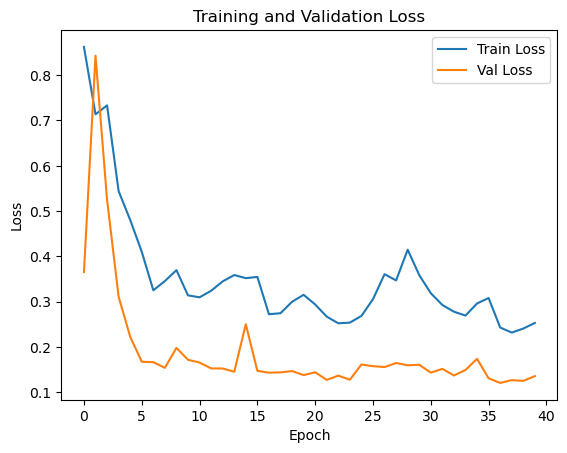

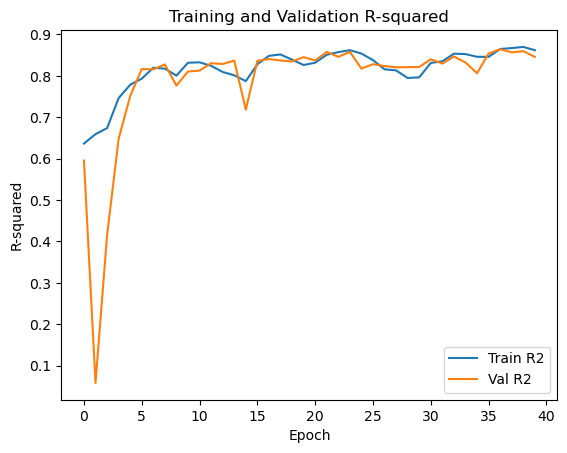

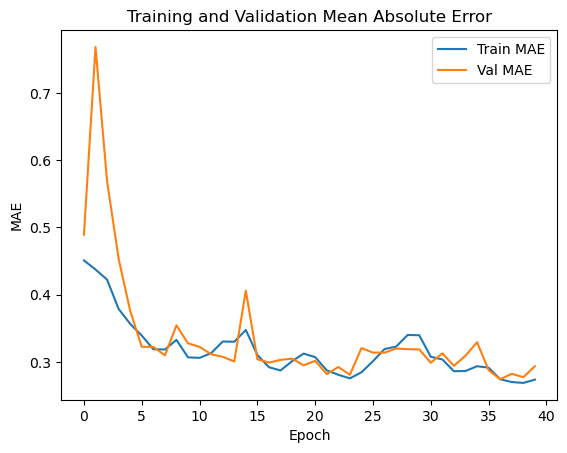

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, mean_absolute_error

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define number of epochs
num_epochs = 40

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Lists to store R-squared values and MAE
train_r2_scores = []
val_r2_scores = []
train_maes = []
val_maes = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        
    predictions_train = []
    targets_train = []
    for inputs, targets in train_loader:
        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        # Collect predictions and targets for calculating R-squared and MAE
        predictions_train.append(outputs.detach().numpy())
        targets_train.append(targets.numpy())
    
    # Calculate R-squared and MAE for training set
    predictions_train = np.concatenate(predictions_train)
    predictions_train = predictions_train.reshape(predictions_train.shape[0], -1)
    targets_train = np.concatenate(targets_train)
    targets_train = targets_train.reshape(targets_train.shape[0], -1)
    train_r2 = r2_score(targets_train, predictions_train)
    train_mae = mean_absolute_error(targets_train, predictions_train)
    
    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2)
    train_maes.append(train_mae)
    
    # Validation
    model.eval()
    val_loss = 0.0
    predictions_val = []
    targets_val = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            # Collect predictions and targets for calculating R-squared and MAE
            predictions_val.append(outputs.detach().numpy())
            targets_val.append(targets.numpy())
    
    # Calculate R-squared and MAE for validation set
    predictions_val = np.concatenate(predictions_val)
    predictions_val = predictions_val.reshape(predictions_val.shape[0], -1)
    targets_val = np.concatenate(targets_val)
    targets_val = targets_val.reshape(targets_val.shape[0], -1)
    val_r2 = r2_score(targets_val, predictions_val)
    val_mae = mean_absolute_error(targets_val, predictions_val)
    
    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_r2_scores.append(val_r2)
    val_maes.append(val_mae)
    
    # Print training/validation statistics
    print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train R2: {train_r2:.4f}, Val R2: {val_r2:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}')

# Plotting loss and metrics
import matplotlib.pyplot as plt

# Loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# R-squared
plt.plot(train_r2_scores, label='Train R2')
plt.plot(val_r2_scores, label='Val R2')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.title('Training and Validation R-squared')
plt.legend()
plt.show()

# MAE
plt.plot(train_maes, label='Train MAE')
plt.plot(val_maes, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation Mean Absolute Error')
plt.legend()
plt.show()

In [24]:
model.eval()

with torch.no_grad():
    predictions_test = []
    targets_test = []

    for inputs, targets in test_loader:

        # Generate predictions
        outputs, _ = model(inputs)

        # Store predictions and targets for evaluation
        predictions_test.append(outputs.cpu().numpy())
        targets_test.append(targets.cpu().numpy())

# Concatenate all batches
predictions_test = np.concatenate(predictions_test, axis=0)
targets_test = np.concatenate(targets_test, axis=0)

# Flatten the arrays to make them compatible with scikit-learn metrics
predictions_test_flat = predictions_test.reshape(-1)
targets_test_flat = targets_test.reshape(-1)

# Calculate R² and MAE
test_r2 = r2_score(targets_test_flat, predictions_test_flat)
test_mae = mean_absolute_error(targets_test_flat, predictions_test_flat)

print(f'Test R²: {test_r2:.4f}')
print(f'Test MAE: {test_mae:.4f}')

Test R²: 0.8650
Test MAE: 0.2904


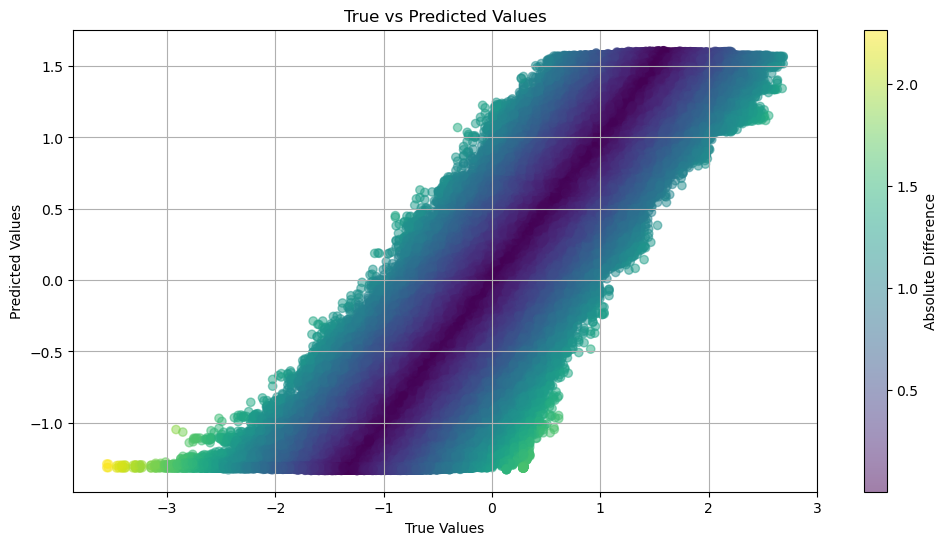

In [25]:
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
y_true_test = np.array(targets_test)
y_pred_test = np.array(predictions_test)

abs_diff = np.abs(targets_test_flat - predictions_test_flat)

# Plot true vs predicted values with color-coded scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(targets_test_flat, predictions_test_flat, c=abs_diff, cmap='viridis', alpha=0.5)
plt.colorbar(label='Absolute Difference')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.grid(True)
plt.show()

In [26]:
print('Targets',y_true_test.shape)
print('Predictions',y_pred_test.shape)

Targets (125, 12, 1, 64, 25)
Predictions (125, 12, 1, 64, 25)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Get the last sequence from actual data
last_sequence = stacked_array[625:637, :, :, :]

# Convert to PyTorch tensor and add batch dimension
last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)

# Make forecast for one time step
with torch.no_grad():
    future_forecast, _ = model(last_sequence_tensor.to(device))  # Use only the first output of the model

# Extract the forecasted data
future_forecast = future_forecast.squeeze().cpu().numpy()

print(future_forecast)

[[[-0.5433856  -0.71318924 -0.74693274 ... -0.7540549  -0.7465846
   -0.58245254]
  [-0.79012793 -0.9796036  -1.0133805  ... -1.01888    -1.0069575
   -0.82938313]
  [-0.8452599  -1.0245509  -1.048864   ... -1.0386438  -1.0302517
   -0.8544296 ]
  ...
  [-1.0695477  -1.1107562  -1.1098058  ... -1.1180049  -1.1147959
   -1.0645461 ]
  [-1.0721079  -1.1118858  -1.112301   ... -1.1140337  -1.109248
   -1.0593982 ]
  [-1.0161736  -1.1170468  -1.117076   ... -1.1157439  -1.1104063
   -1.0019164 ]]

 [[-0.36594254 -0.45335466 -0.52830267 ... -0.4709851  -0.4633959
   -0.41115567]
  [-0.5113196  -0.60300875 -0.66876644 ... -0.6035998  -0.5948805
   -0.54121846]
  [-0.56807834 -0.63823485 -0.6838689  ... -0.621246   -0.615885
   -0.56666106]
  ...
  [-1.204097   -1.230874   -1.2181342  ... -1.2010964  -1.211934
   -1.182541  ]
  [-1.2134131  -1.2402743  -1.231952   ... -1.2113895  -1.2208852
   -1.1897153 ]
  [-1.2155737  -1.2490394  -1.2432823  ... -1.229237   -1.2360771
   -1.1877201 ]]

 [[

In [28]:
forecasts = future_forecast

In [29]:
forecasts_2d = forecasts.reshape(-1, 1)

# Reshape the data to 2D array
data_2d = temp.reshape(-1, 1)

# Fit the scaler on the original data
scaler.fit(data_2d)

# Now you can use it to revert the normalization
reverted_forecasts_2d = scaler.inverse_transform(forecasts_2d)

# Reshape the reverted data back to its original shape
reverted_forecasts = reverted_forecasts_2d.reshape(forecasts.shape)

In [30]:
reverted_forecasts.shape

(12, 64, 25)

In [31]:
temp_last_12 = temp_last[12:, :, :]
print(temp_last_12.shape)
reverted_forecasts = reverted_forecasts[:11,:,:]
print(reverted_forecasts.shape)

(11, 64, 25)
(11, 64, 25)


In [32]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual_Temp': temp_last_12.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted_Temp': reverted_forecasts.flatten()
})

# Display the DataFrame
print(comparison_df)

       Actual_Temp  Predicted_Temp
0         7.855073        5.613393
1         8.141992        4.837522
2         7.609971        4.683340
3         7.508132        4.597914
4         7.734407        4.556244
...            ...             ...
17595     2.712619        2.446786
17596     3.238767        2.446228
17597     2.817050        2.437388
17598     3.016657        2.423101
17599     2.800413        2.464469

[17600 rows x 2 columns]


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: 0.9202802272038078
Mean Absolute Error: 1.0984216873164785
Mean Squared Error: 1.8443108603509446


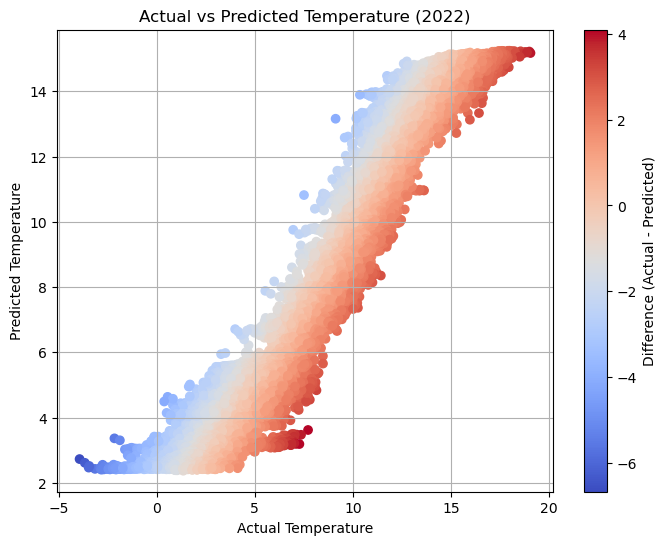

In [34]:
# Calculate the difference between actual and predicted temperature
comparison_df['Difference'] = comparison_df['Actual_Temp'] - comparison_df['Predicted_Temp']

# Create a scatter plot with a colormap representing the difference
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'], c=comparison_df['Difference'], cmap='coolwarm')

# Add labels and title
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature (2022)')

# Add colorbar
plt.colorbar(label='Difference (Actual - Predicted)')

# Show the plot
plt.grid(True)
plt.show()

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Get the last sequence from actual data
last_sequence = stacked_array[625:626, :, :, :]

# Convert to PyTorch tensor and add batch dimension
last_sequence_tensor = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0)

# Make forecast for one time step
with torch.no_grad():
    future_forecast, _ = model(last_sequence_tensor.to(device))  # Use only the first output of the model

# Extract the forecasted data
future_forecast = future_forecast.squeeze().cpu().numpy()

print(future_forecast)

[[-0.5433856  -0.71318924 -0.74693274 ... -0.7540549  -0.7465846
  -0.58245254]
 [-0.79012793 -0.9796036  -1.0133805  ... -1.01888    -1.0069575
  -0.82938313]
 [-0.8452599  -1.0245509  -1.048864   ... -1.0386438  -1.0302517
  -0.8544296 ]
 ...
 [-1.0695477  -1.1107562  -1.1098058  ... -1.1180049  -1.1147959
  -1.0645461 ]
 [-1.0721079  -1.1118858  -1.112301   ... -1.1140337  -1.109248
  -1.0593982 ]
 [-1.0161736  -1.1170468  -1.117076   ... -1.1157439  -1.1104063
  -1.0019164 ]]


In [36]:
forecasts = future_forecast

In [37]:
forecasts_2d = forecasts.reshape(-1, 1)

# Reshape the data to 2D array
data_2d = temp.reshape(-1, 1)

# Fit the scaler on the original data
scaler.fit(data_2d)

# Now you can use it to revert the normalization
reverted_forecasts_2d = scaler.inverse_transform(forecasts_2d)

# Reshape the reverted data back to its original shape
reverted_forecasts = reverted_forecasts_2d.reshape(forecasts.shape)

In [38]:
temp_last_1 = temp_last[0:1, :, :]
print(temp_last_1.shape)
print(reverted_forecasts.shape)

(1, 64, 25)
(64, 25)


In [39]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual_Temp': temp_last_1.flatten(),  # Flatten to make sure it's a 1D array
    'Predicted_Temp': reverted_forecasts.flatten()
})

# Display the DataFrame
print(comparison_df)

      Actual_Temp  Predicted_Temp
0        5.751674        5.613393
1        6.024978        4.837522
2        5.465040        4.683340
3        5.347346        4.597914
4        5.551682        4.556244
...           ...             ...
1595     2.252714        3.061849
1596     2.440190        3.031555
1597     1.936387        2.998158
1598     2.077550        3.022546
1599     1.813093        3.518261

[1600 rows x 2 columns]


In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: -1.0936434505507489
Mean Absolute Error: 1.522463886912401
Mean Squared Error: 3.378729152429859


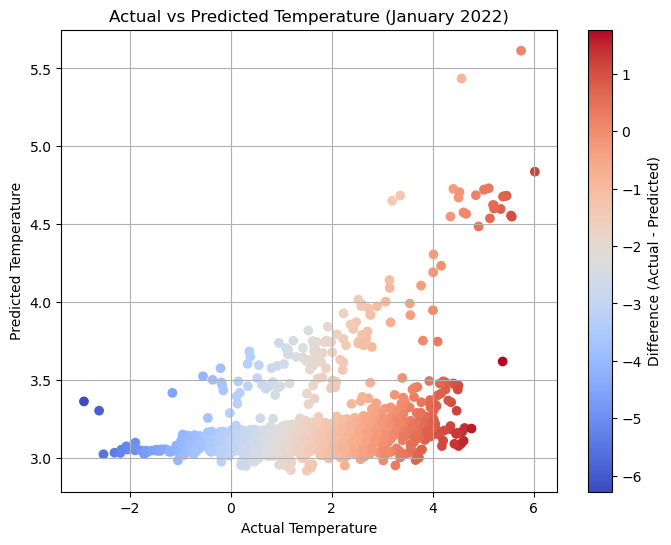

In [41]:
# Calculate the difference between actual and predicted temperature
comparison_df['Difference'] = comparison_df['Actual_Temp'] - comparison_df['Predicted_Temp']

# Create a scatter plot with a colormap representing the difference
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'], c=comparison_df['Difference'], cmap='coolwarm')

# Add labels and title
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature (January 2022)')

# Add colorbar
plt.colorbar(label='Difference (Actual - Predicted)')

# Show the plot
plt.grid(True)
plt.show()